In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv(".\dataset\water_leak_detection_1000_rows.csv")

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
C:\Users\minae\AppData\Local\Temp\ipykernel_11544\413255387.py:4: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv(".\dataset\water_leak_detection_1000_rows.csv")


In [4]:
# Explore the data
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nMissing values:")
print(df.isnull().sum().sum())

print(df.columns)

Dataset shape: (1000, 7)

First few rows:
             Timestamp Sensor_ID  Pressure (bar)  Flow Rate (L/s)  \
0  2024-01-01 00:00:00      S007        3.694814        77.515218   
1  2024-01-01 00:05:00      S007        2.587125       179.926422   
2  2024-01-01 00:10:00      S002        2.448965       210.130823   
3  2024-01-01 00:15:00      S009        2.936844       141.777934   
4  2024-01-01 00:20:00      S003        3.073693       197.484633   

   Temperature (°C)  Leak Status  Burst Status  
0         21.695365            0             0  
1         19.016725            0             0  
2         10.011681            1             0  
3         12.092408            0             0  
4         17.001443            0             0  

Missing values:
0
Index(['Timestamp', 'Sensor_ID', 'Pressure (bar)', 'Flow Rate (L/s)',
       'Temperature (°C)', 'Leak Status', 'Burst Status'],
      dtype='object')


<Axes: title={'center': 'Leak Status Distribution'}, xlabel='Leak Status'>

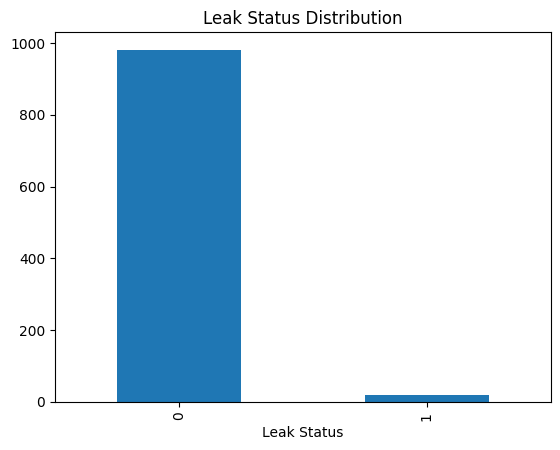

In [5]:
df['Leak Status'].value_counts().plot(kind='bar', title='Leak Status Distribution')